# Thesis Allocation Problem

This notebook containts a basic and more complex implementation of the thesis allocation problem: allocating thesis topics to students based on factors such as preference and limits to the number of students per lecturer.

## 1. A Basic Implementation
### Details
- There are $n$ students and $m$ topics. $m \geq n$.
- There are $k$ topic preferences chosen randomly and ranked according to index in array (e.g. index 0 corresponds with 1st choice)
- A student must only have 1 topic
- A topic must have 1 or no students
- Cost is assigned to preferences as follows:
$$P = [p_1, p_2, ..., p_k]$$ 
$$P_{cost} = [0, 1, ..., k-1]$$
Any topic allocation not in the student's preferences receives $cost=k$

In [27]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [28]:
num_students = 100 # n
num_topics = 120 # m
num_preferences = 6 # k

students = range(num_students)
topics = range(num_topics)

# Create preferences per student by randomly samply k out of m topics
preferences = np.array([random.sample(topics,k=num_preferences) for i in students])

In order to formulate the optimization problem, a preference-cost matrix was constructed. This matrix has a row for each student (n rows), and a column for each topic (m topics). Each topic is given a cost based on the student's preferences. 

For example, if there are 3 topics and a student has 2 preferences, topic 3 (first choice) and topic 1 (second choice), the matrix would look something like this:

$$
PrefCost=\left[\begin{array}{cc} 
1 & 2 & 0
\end{array}\right]
$$ 

So if the student was awarded topic 1, they would incur a cost of 1, etc.

In [29]:
preferences_cost = np.full((len(students),len(topics)), num_preferences)

for i in students:
    for k in range(num_preferences):
        preferences_cost[i,preferences[i,k]] = k
        
preferences_cost = preferences_cost.tolist()

Now, the optimization problem can be formulated.

In [30]:
from mip import Model, xsum, minimize, BINARY, OptimizationStatus

m = Model()

x = [[m.add_var('x({}{})'.format(i,j), var_type=BINARY) 
     for i in topics] for j in students]

# CONSTRAINTS
# One topic per student
for i in students:
    m += xsum(x[i][j] for j in topics) == 1
    
# One student per topic
for j in topics:
    m += xsum(x[i][j] for i in students) <= 1
    
# OBJECTIVE FUNCTION
# Minimize the cost of preferences of topics
m.objective = minimize(xsum(preferences_cost[j][i]*x[j][i] for i in topics for j in students))

In [31]:
status = m.optimize()

if status == OptimizationStatus.OPTIMAL:
    print('optimal solution cost {} found'.format(m.objective_value))
elif status == OptimizationStatus.FEASIBLE:
    print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
elif status == OptimizationStatus.NO_SOLUTION_FOUND:
    print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
elif status == OptimizationStatus.INFEASIBLE:
    print('Problem is infeasible')

optimal solution cost 58.0 found


If an optimal solution was found, we can now look at the "printed histogram" of the results.

In [32]:
results = np.zeros((num_students,num_topics),dtype=np.uint8)
if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
    for i in students:
        for j in topics:
            results[i,j] = x[i][j].x

summary_count = np.zeros((num_preferences+1))
for i in students:
    topic_choice = str(results[i].argmax())
    if np.where(preferences[i] == results[i].argmax())[0].shape[0]:
        preference_rank = str(np.where(preferences[i] == results[i].argmax())[0][0])
        summary_count[np.where(preferences[i] == results[i].argmax())[0][0]] +=1
    else:
        preference_rank = "OOB"
        summary_count[-1] +=1
#     print("Student {} chose topic {} - preference {}".format(str(i), topic_choice, preference_rank))

perc_arr = []
print("Out of {} students...".format(num_students))
for i in range(num_preferences+1):
    perc = str(round(summary_count[i]/num_students*100,1))
    if i == num_preferences:
        print("{}% students were not allocated a topic from their preferences".format(perc))
    else:
        print("{}% students get preference {}".format(perc, i))
    perc_arr.append(float(perc))

Out of 100 students...
56.0% students get preference 0
31.0% students get preference 1
12.0% students get preference 2
1.0% students get preference 3
0.0% students get preference 4
0.0% students get preference 5
0.0% students were not allocated a topic from their preferences


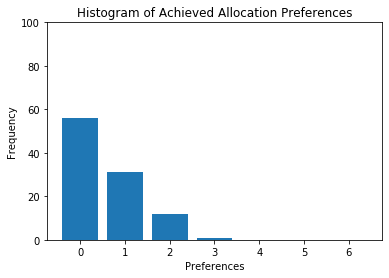

In [34]:
x_labs = np.arange(num_preferences+1)
plt.bar(x_labs[::-1], height=perc_arr[::-1])
plt.xticks(x_labs, x_labs)
plt.title("Histogram of Achieved Allocation Preferences")
plt.ylabel("Frequency")
plt.xlabel("Preferences")
plt.ylim((0,100))
plt.show()

---

## 2. A More Complex Implementation
### Details
- There are $n$ students and $m$ topics. $m \geq n$.
- There are $k$ topic preferences chosen randomly and ranked according to index in array (e.g. index 0 corresponds with 1st choice)
- Each lecturer has $i$ topics. 
- A lecturere may have no more than $h$ students.
- A student must only have 1 topic
- A topic must have 1 or no students
- Cost is assigned to preferences as follows:
$$P = [p_1, p_2, ..., p_k]$$ 
$$P_{cost} = [0, 1, ..., k-1]$$
Any topic allocation not in the student's preferences receives $cost=k$

In [43]:
import random
import numpy as np

num_students = 100 # n
num_preferences = 6 # k
topics_per_lecturer = 5 # i
num_lecturers = 27
num_topics = num_lecturers*topics_per_lecturer # m
max_students_per_lecturer = 4 # h

students = range(num_students)
lecturers = range(num_lecturers)
topics = range(num_topics)

topics_list = np.linspace(0,num_topics-1,num_topics,dtype=np.uint32)

preferences = np.array([random.sample(topics,k=num_preferences) for i in students])
preferences_cost = np.full((len(students),len(topics)), num_preferences)

for i in students:
    for k in range(num_preferences):
        preferences_cost[i,preferences[i,k]] = k
        
preferences_cost = preferences_cost.tolist()

In order to add the lecturer limit to the problem, a mask was created for each lecturer describing which of the topics were theirs. 

For example, if there are 10 topics and the first 3 topics below to lecturer 1, the mask for lecturer 1 would look like this:

$$
mask_1=\left[\begin{array}{cc} 
1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0
\end{array}\right]
$$ 


In [43]:
lecturer_mask = np.zeros((num_lecturers,num_topics), dtype=np.uint32)
for i in lecturers:
    lecturer_mask[i,i*topics_per_lecturer:i*topics_per_lecturer+topics_per_lecturer] = 1

Again, we can formulate the problem but this time with the added constraint on topics per lecturer.

In [51]:
from mip import Model, xsum, minimize, BINARY, OptimizationStatus

m = Model()

x = [[m.add_var('x({}{})'.format(i,j), var_type=BINARY) 
     for i in topics] for j in students]

# CONSTRAINTS
for i in students:
    m += xsum(x[i][j] for j in topics) == 1
    
for j in topics:
    m += xsum(x[i][j] for i in students) <= 1

for l in lecturers:
    mask = lecturer_mask[l]
    m += xsum(x[i][j]*mask[j] for j in topics for i in students) <= max_students_per_lecturer
    
# OBJECTIVE FUNCTION
# Minimize the cost of preferences of topics
m.objective = minimize(xsum(preferences_cost[j][i]*x[j][i] for i in topics for j in students))

In [52]:
status = m.optimize()

if status == OptimizationStatus.OPTIMAL:
    print('optimal solution cost {} found'.format(m.objective_value))
elif status == OptimizationStatus.FEASIBLE:
    print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
elif status == OptimizationStatus.NO_SOLUTION_FOUND:
    print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
elif status == OptimizationStatus.INFEASIBLE:
    print('Problem is infeasible')

optimal solution cost 54.0 found


In [53]:
results = np.zeros((num_students,num_topics),dtype=np.uint8)
if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
    for i in students:
        for j in topics:
            results[i,j] = x[i][j].x

summary_count = np.zeros((num_preferences+1))
for i in students:
    topic_choice = str(results[i].argmax())
    if np.where(preferences[i] == results[i].argmax())[0].shape[0]:
        preference_rank = str(np.where(preferences[i] == results[i].argmax())[0][0])
        summary_count[np.where(preferences[i] == results[i].argmax())[0][0]] +=1
    else:
        preference_rank = "OOB"
        summary_count[-1] +=1
#     print("Student {} chose topic {} - preference {}".format(str(i), topic_choice, preference_rank))

In [54]:
print("Out of {} students...".format(num_students))
for i in range(num_preferences+1):
    perc = str(round(summary_count[i]/num_students*100,1))
    if i == num_preferences:
        print("{}% students were not allocated a topic from their preferences".format(perc))
    else:
        print("{}% students get preference {}".format(perc, i))

Out of 100 students...
63.0% students get preference 0
23.0% students get preference 1
11.0% students get preference 2
3.0% students get preference 3
0.0% students get preference 4
0.0% students get preference 5
0.0% students were not allocated a topic from their preferences


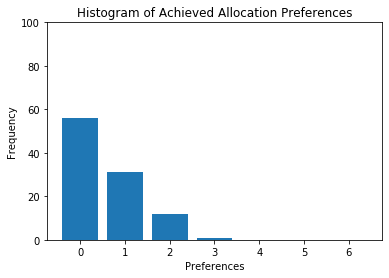

In [55]:
x_labs = np.arange(num_preferences+1)
plt.bar(x_labs[::-1], height=perc_arr[::-1])
plt.xticks(x_labs, x_labs)
plt.title("Histogram of Achieved Allocation Preferences")
plt.ylabel("Frequency")
plt.xlabel("Preferences")
plt.ylim((0,100))
plt.show()

In [58]:
topics_aggregate = np.zeros(num_topics,dtype=np.uint8)
    
for i in students:
    topics_aggregate = np.bitwise_or(topics_aggregate, results[i])

topics_aggregate = topics_aggregate.reshape(num_lecturers, topics_per_lecturer)

summary_lecturers = np.zeros(max_students_per_lecturer+1)
for l in lecturers:
    students_per_lecturer = np.sum(topics_aggregate[l])
    summary_lecturers[students_per_lecturer] += 1
    
print("Out of {} lecturers...".format(num_lecturers))
for i in range(max_students_per_lecturer+1):
    perc = str(round(summary_lecturers[i]/num_lecturers*100,1))
    print("{}% lecturers were allocated {} students".format(perc, i))

Out of 27 lecturers...
0.0% lecturers were allocated 0 students
0.0% lecturers were allocated 1 students
3.7% lecturers were allocated 2 students
22.2% lecturers were allocated 3 students
74.1% lecturers were allocated 4 students
